In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# # 1 · Environment setup & data download  
# We install the vision-language model (CLIP/BLIP) dependencies and pull  
# the NWPU-RESISC45 dataset from Kaggle so the rest of the pipeline has
# everything it needs on disk.


In [2]:
# original code starts right after the Markdown cell
import kagglehub
punfake_resisc45_path = kagglehub.dataset_download('punfake/resisc45')
print('Data source import complete.')

!git clone https://github.com/ChunpingQiu/VLM_FS-RSI-SC.git /kaggle/working/VLM_FS-RSI-SC

!pip install salesforce-lavis
!pip install clip
!pip uninstall -y clip
!pip install --upgrade git+https://github.com/openai/CLIP.git


Data source import complete.
Cloning into '/kaggle/working/VLM_FS-RSI-SC'...
remote: Enumerating objects: 31548, done.
remote: Counting objects: 100% (31548/31548), done.
remote: Compressing objects: 100% (31547/31547), done.
remote: Total 31548 (delta 0), reused 31548 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31548/31548), 33.45 MiB | 29.53 MiB/s, done.
Updating files: 100% (31505/31505), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.5 MB/s eta 0:00:00
   

In [3]:
# ---- 1.1  install libs ----------------------------------------------------
!pip install -q open-clip-torch==2.24.0 huggingface_hub --extra-index-url https://download.pytorch.org/whl/cu121
# (optional) for speed on A100, enable Flash-Attention 2
# !pip install -q flash-attn --no-build-isolation

# ---- 1.2  download RemoteCLIP weight -------------------------------------
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(
    repo_id = "chendelong/RemoteCLIP",
    filename = "RemoteCLIP-ViT-L-14.pt",
    cache_dir = "/kaggle/working/remoteclip_ckpt"   # feels at home in /working
)
print("✅ checkpoint saved to", ckpt_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.2 MB/s eta 0:00:00


RemoteCLIP-ViT-L-14.pt:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

✅ checkpoint saved to /kaggle/working/remoteclip_ckpt/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt


In [4]:
%%bash
PATCH_FILE=/kaggle/working/VLM_FS-RSI-SC/saveFeatures_subfolder_aid_nwpu_whu.py

sed -n '1,120p' $PATCH_FILE | grep -n "create_model_and_transforms"    # sanity-peek

# ---- inject RemoteCLIP ckpt load right after model creation -------------
sed -i '/create_model_and_transforms/a\
import torch, os\n\
_ckpt = os.environ.get("REMOTECLIP_CKPT", "")\n\
if _ckpt and os.path.isfile(_ckpt):\n\
    print(f"🔄  Loading RemoteCLIP weights → {_ckpt}")\n\
    model.load_state_dict(torch.load(_ckpt, map_location="cpu"))' $PATCH_FILE
echo "✅ Patched saveFeatures script to recognise REMOTECLIP_CKPT"


✅ Patched saveFeatures script to recognise REMOTECLIP_CKPT


In [5]:
import os

for dirname, _, _ in os.walk('/kaggle/input'):
    if 'nwpu' in dirname.lower():
        print(f"Found relevant directory: {dirname}")
        sample = os.listdir(dirname)[:10]
        print("Contents sample:", sample)
        # quick check for image files
        if any(f.lower().endswith(('.jpg','.jpeg','.png','.tif')) for f in os.listdir(dirname)):
            print("✅ Contains image files!")
        break


Found relevant directory: /kaggle/input/resisc45/NWPU-RESISC45
Contents sample: ['airplane', 'cloud', 'mountain', 'medium_residential', 'thermal_power_station', 'terrace', 'commercial_area', 'dense_residential', 'baseball_diamond', 'mobile_home_park']


In [6]:
import os
os.environ["REMOTECLIP_CKPT"] = "/kaggle/working/remoteclip_ckpt/RemoteCLIP-ViT-L-14.pt"



# ## 2 · Sanity-check the downloaded dataset  
# Let’s quickly list the contents of **/kaggle/input** to make sure the
# NWPU-RESISC45 archive (and any other resources) have landed where we
# expect. Seeing the class-folder structure here saves us from debugging
# missing-file errors later on.


# ## 3 · Define train / val / test class splits  
# We carve the NWPU-RESISC45 dataset into **25 training classes**, **10
# validation classes**, and **10 held-out test classes**.  
#   
# *Why?*  
# – Keeps unseen-class evaluation honest (no leakage).  
# – Lets us tune hyper-parameters on *val* while preserving a clean *test*.  
#   
# The next code cell:  
# 1. Lists the three class groups in a `splits` dictionary.  
# 2. Creates an on-disk folder tree `/kaggle/working/nwpu-resisc45/{train,val,test}/CLASS/`.  
# 3. Copies every image into its split so downstream scripts can
#    iterate over plain directories instead of filtering on the fly.


In [7]:
import os, shutil
from pathlib import Path

# Location of the raw 45-class archive from Kaggle
SRC_ROOT = '/kaggle/input/resisc45/NWPU-RESISC45'

# Where we will build the split directory tree
DST_ROOT = '/kaggle/working/nwpu-resisc45'

# --- class lists ---
splits = {
    'train': [
        "airplane","baseball_diamond","beach","bridge","chaparral","church","cloud",
        "desert","freeway","golf_course","harbor","island","lake","meadow",
        "mobile_home_park","mountain","palace","railway","rectangular_farmland",
        "roundabout","sea_ice","ship","sparse_residential","stadium","wetland"
    ],
    'val': [
        "commercial_area","industrial_area","overpass","railway_station","runway",
        "snowberg","storage_tank","tennis_court","terrace","thermal_power_station"
    ],
    'test': [
        "airport","basketball_court","circular_farmland","dense_residential","forest",
        "ground_track_field","intersection","medium_residential","parking_lot","river"
    ]
}

In [8]:
# 1) Create empty folders for every split / class
for split, classes in splits.items():
    for cls in classes:
        Path(DST_ROOT, split, cls).mkdir(parents=True, exist_ok=True)

In [9]:
# 2) Copy every image of each class into its split folder
VALID_EXTS = ('.jpg', '.jpeg', '.png', '.tif', '.tiff')
for split, classes in splits.items():
    for cls in classes:
        src_dir = os.path.join(SRC_ROOT, cls)
        dst_dir = os.path.join(DST_ROOT, split, cls)
        if not os.path.isdir(src_dir):
            print(f"⚠ Missing {src_dir}")
            continue
        imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(VALID_EXTS)]
        print(f"Copying {len(imgs)} images → {split}/{cls}")
        for img in imgs:
            shutil.copy(os.path.join(src_dir, img), dst_dir)

Copying 700 images → train/airplane
Copying 700 images → train/baseball_diamond
Copying 700 images → train/beach
Copying 700 images → train/bridge
Copying 700 images → train/chaparral
Copying 700 images → train/church
Copying 700 images → train/cloud
Copying 700 images → train/desert
Copying 700 images → train/freeway
Copying 700 images → train/golf_course
Copying 700 images → train/harbor
Copying 700 images → train/island
Copying 700 images → train/lake
Copying 700 images → train/meadow
Copying 700 images → train/mobile_home_park
Copying 700 images → train/mountain
Copying 700 images → train/palace
Copying 700 images → train/railway
Copying 700 images → train/rectangular_farmland
Copying 700 images → train/roundabout
Copying 700 images → train/sea_ice
Copying 700 images → train/ship
Copying 700 images → train/sparse_residential
Copying 700 images → train/stadium
Copying 700 images → train/wetland
Copying 700 images → val/commercial_area
Copying 700 images → val/industrial_area
Copying

In [10]:
# 3) Quick report: how many classes in each split?
for split in ['train', 'val', 'test']:
    path = os.path.join(DST_ROOT, split)
    classes = sorted(d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d)))
    print(f"✔ {split}: {len(classes)} classes → {classes}")

✔ train: 25 classes → ['airplane', 'baseball_diamond', 'beach', 'bridge', 'chaparral', 'church', 'cloud', 'desert', 'freeway', 'golf_course', 'harbor', 'island', 'lake', 'meadow', 'mobile_home_park', 'mountain', 'palace', 'railway', 'rectangular_farmland', 'roundabout', 'sea_ice', 'ship', 'sparse_residential', 'stadium', 'wetland']
✔ val: 10 classes → ['commercial_area', 'industrial_area', 'overpass', 'railway_station', 'runway', 'snowberg', 'storage_tank', 'tennis_court', 'terrace', 'thermal_power_station']
✔ test: 10 classes → ['airport', 'basketball_court', 'circular_farmland', 'dense_residential', 'forest', 'ground_track_field', 'intersection', 'medium_residential', 'parking_lot', 'river']


In [11]:
# ─────────────────────────────  Cell 1: NWPU-RESISC45  ─────────────────────────────
# --- CONFIG -----------------------------------------------------------
DATASET    = "nwpu-resisc45"
MODEL_NAME = "ViT-L/14"
WAY        = 45
ROOT       = "/kaggle/working/"
# ---------------------------------------------------------------------

import os, subprocess, re

# ensure RemoteCLIP checkpoint is set
assert os.environ.get("REMOTECLIP_CKPT"), "Set REMOTECLIP_CKPT first!"

# 1) Feature extraction
print(f"🔍 Extracting features for {DATASET} with {MODEL_NAME}…")
!python /kaggle/working/VLM_FS-RSI-SC/saveFeatures_subfolder_aid_nwpu_whu.py \
      --model_source clip \
      --model_name $MODEL_NAME \
      --root  $ROOT \
      --dataset $DATASET

🔍 Extracting features for nwpu-resisc45 with ViT-L/14…
Torch version: 2.6.0+cu124
2025-05-26 20:06:15.951421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748289976.150910     162 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748289976.206901     162 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload

In [12]:
# 2) Few-shot evaluation
def get_acc(dataset, model_name, way):
    cmd = [
        "python", "/kaggle/working/VLM_FS-RSI-SC/classifier_fromFeatures.py",
        "--root",  f"{ROOT}clip_exp/features/{model_name}/",
        "--dataset", dataset,
        "--way",    str(way),
        "--sets",   "train", "val", "test"
    ]
    out = subprocess.run(cmd, capture_output=True, text=True).stdout
    m = re.search(r',\s*([\d.]+)\s*±.*?,\s*([\d.]+)\s*±', out)
    return (float(m.group(1)), float(m.group(2))) if m else (_:=out, None)

acc1, acc5 = get_acc(DATASET, MODEL_NAME, WAY)
print(f"✔ {DATASET.upper()} – 1-shot {acc1:.2f}%   5-shot {acc5:.2f}%")

✔ NWPU-RESISC45 – 1-shot 57.68%   5-shot 81.90%


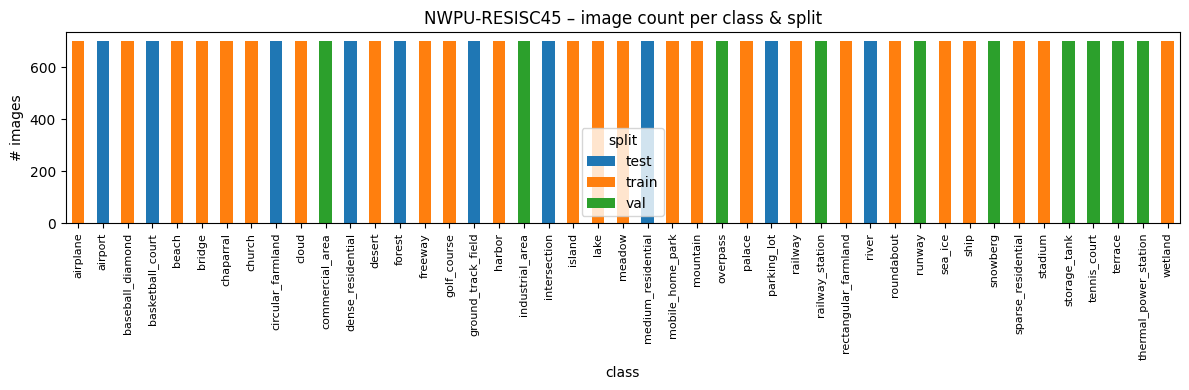

        dim          L2_norm        
      first   mean     first    mean
split                               
test    768  768.0  0.999023  0.9998
train   768  768.0  1.000000  0.9998
val     768  768.0  1.000000  0.9999


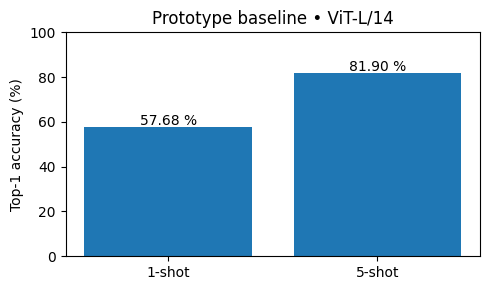

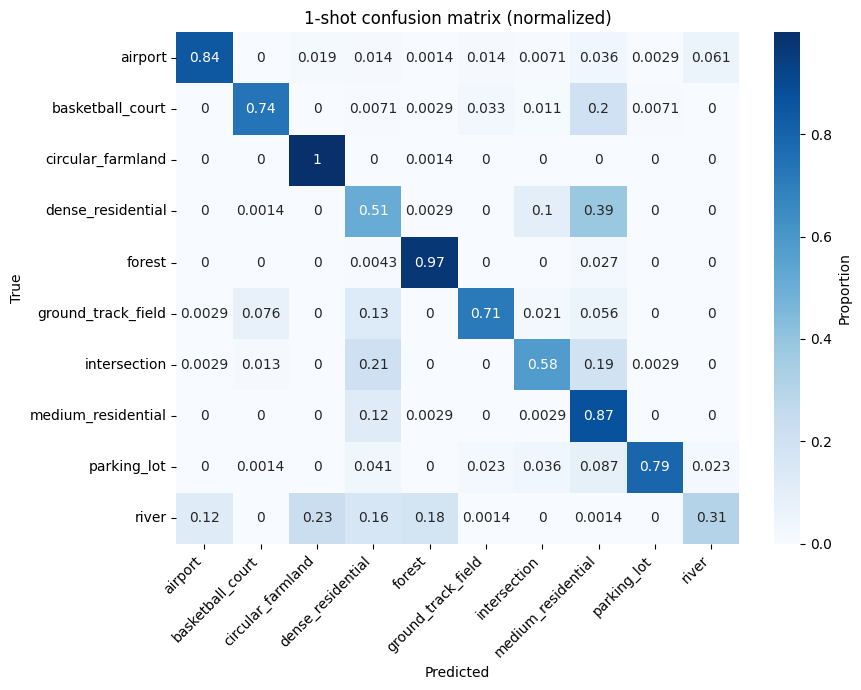

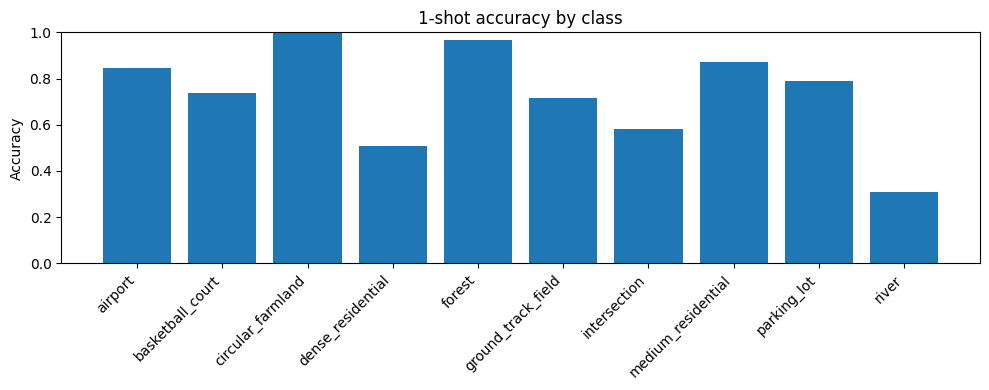


=== 1-shot classification report ===
                    precision    recall  f1-score   support

           airport     0.8704    0.8443    0.8571       700
  basketball_court     0.8895    0.7357    0.8053       700
 circular_farmland     0.8016    0.9986    0.8893       700
 dense_residential     0.4241    0.5071    0.4619       700
            forest     0.8339    0.9686    0.8962       700
ground_track_field     0.9091    0.7143    0.8000       700
      intersection     0.7617    0.5800    0.6586       700
medium_residential     0.4677    0.8700    0.6084       700
       parking_lot     0.9840    0.7886    0.8755       700
             river     0.7847    0.3071    0.4415       700

          accuracy                         0.7314      7000
         macro avg     0.7727    0.7314    0.7294      7000
      weighted avg     0.7727    0.7314    0.7294      7000



In [13]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# ---------- paths ------------------------------------------------------
SRC_ROOT  = Path(f"/kaggle/working/{DATASET}")                        # raw images
FEAT_ROOT = Path(f"/kaggle/working/clip_exp/features/{MODEL_NAME}/{DATASET}")
TEST_ROOT = FEAT_ROOT / "test"
test_classes = sorted(p.name for p in TEST_ROOT.iterdir() if p.is_dir())
# ----------------------------------------------------------------------

# 1) image counts per class & split ------------------------------------
records = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(SRC_ROOT / split)):
        records.append({
            "split":  split,
            "class":  cls,
            "n_imgs": len(list((SRC_ROOT / split / cls).glob("*")))
        })
pd.DataFrame(records).pivot(index="class", columns="split",
                            values="n_imgs").plot(kind="bar", stacked=True,
                                                  figsize=(12,4))
plt.ylabel("# images")
plt.title(f"{DATASET.upper()} – image count per class & split")
plt.xticks(rotation=90, ha="center", fontsize=8)
plt.tight_layout(); plt.show()

# 2) feature-vector sanity check ---------------------------------------
rows = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(FEAT_ROOT / split)):
        vec = np.load(next((FEAT_ROOT/split/cls).glob("*.npy")))
        rows.append({"split":split,"class":cls,
                     "dim":vec.shape[-1],"L2_norm":np.linalg.norm(vec)})
df_feat = pd.DataFrame(rows)
print(df_feat.groupby("split")[["dim","L2_norm"]].agg(["first","mean"]).round(4))

# 3) quick 1-shot inference -------------------------------------------
prototypes = {cls: np.load(next((TEST_ROOT/cls).glob("*.npy"))).squeeze()
              for cls in test_classes}
y_true, y_pred = [], []
for true_cls in test_classes:
    for fpath in (TEST_ROOT/true_cls).glob("*.npy"):
        feat = np.load(fpath).squeeze()
        sims = [np.dot(feat, prototypes[c]) for c in test_classes]
        y_true.append(true_cls)
        y_pred.append(test_classes[int(np.argmax(sims))])

# 4) bar plot of 1-shot / 5-shot --------------------------------------
plt.figure(figsize=(5,3))
bars = plt.bar(["1-shot","5-shot"], [acc1, acc5])
plt.ylim(0,100); plt.ylabel("Top-1 accuracy (%)")
plt.title(f"Prototype baseline • {MODEL_NAME}")
for b,v in zip(bars,[acc1,acc5]):
    plt.text(b.get_x()+b.get_width()/2, v+1, f"{v:.2f} %", ha="center")
plt.tight_layout(); plt.show()
# 5) confusion matrix & per-class acc ---------------------------------
cm = confusion_matrix(y_true, y_pred, labels=test_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, cmap="Blues", annot=True,
            xticklabels=test_classes, yticklabels=test_classes,
            cbar_kws={'label':'Proportion'})
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("1-shot confusion matrix (normalized)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

per_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(10,4))
plt.bar(test_classes, per_acc)
plt.xticks(rotation=45, ha="right"); plt.ylim(0,1)
plt.ylabel("Accuracy"); plt.title("1-shot accuracy by class")
plt.tight_layout(); plt.show()

# 6) detailed classification report -----------------------------------
print("\n=== 1-shot classification report ===")
print(classification_report(y_true, y_pred, target_names=test_classes, digits=4))

### 1 · Sanity-check the UCM archive

In [14]:
# Locate the raw 21-class archive downloaded by KaggleHub
for dirname, _, _ in os.walk('/kaggle/input'):
    if 'uc-merced' in dirname.lower():
        print(f"✅ Found UCM root: {dirname}")
        print("Sample files:", os.listdir(dirname)[:10])
        break


✅ Found UCM root: /kaggle/input/uc-merced-land-use-dataset
Sample files: ['UCMerced_LandUse']


In [15]:
import os, shutil
from pathlib import Path

#  Location of the raw .tif images
SRC_ROOT = '/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images'

#  Where the split directory tree will live
DST_ROOT = '/kaggle/working/ucm'

splits = {
    "train": [
        "agricultural","airplane","baseballdiamond","beach","buildings",
        "chaparral","denseresidential","forest","freeway","golfcourse",
        "harbor","intersection","river"                                 # 13 classes
    ],
    "val":   ["mediumresidential","mobilehomepark","overpass","runway"], # 4
    "test":  ["parkinglot","sparseresidential","storagetanks","tenniscourt"] # 4
}

# (1) create empty folders
for split, classes in splits.items():
    for cls in classes:
        Path(DST_ROOT, split, cls).mkdir(parents=True, exist_ok=True)

# (2) copy .tif images into the split folders
VALID_EXTS = ('.tif', '.tiff', '.jpg', '.jpeg', '.png')
for split, classes in splits.items():
    for cls in classes:
        src_dir = os.path.join(SRC_ROOT, cls)
        dst_dir = os.path.join(DST_ROOT, split, cls)
        imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(VALID_EXTS)]
        print(f"Copying {len(imgs)} imgs → {split}/{cls}")
        for img in imgs:
            shutil.copy(os.path.join(src_dir, img), dst_dir)

# (3) quick report
for split in ["train","val","test"]:
    cls_list = sorted(os.listdir(os.path.join(DST_ROOT, split)))
    print(f"✔ {split}: {len(cls_list)} classes → {cls_list}")


Copying 100 imgs → train/agricultural
Copying 100 imgs → train/airplane
Copying 100 imgs → train/baseballdiamond
Copying 100 imgs → train/beach
Copying 100 imgs → train/buildings
Copying 100 imgs → train/chaparral
Copying 100 imgs → train/denseresidential
Copying 100 imgs → train/forest
Copying 100 imgs → train/freeway
Copying 100 imgs → train/golfcourse
Copying 100 imgs → train/harbor
Copying 100 imgs → train/intersection
Copying 100 imgs → train/river
Copying 100 imgs → val/mediumresidential
Copying 100 imgs → val/mobilehomepark
Copying 100 imgs → val/overpass
Copying 100 imgs → val/runway
Copying 100 imgs → test/parkinglot
Copying 100 imgs → test/sparseresidential
Copying 100 imgs → test/storagetanks
Copying 100 imgs → test/tenniscourt
✔ train: 13 classes → ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'river']
✔ val: 4 classes → ['mediumresidential', 'mobilehomepark

In [16]:
# ─────────────────────────────  Cell 2: UCM  ─────────────────────────────
# --- CONFIG -----------------------------------------------------------
DATASET    = "ucm"
MODEL_NAME = "ViT-L/14"
WAY        = 21
ROOT       = "/kaggle/working/"
# ---------------------------------------------------------------------

import os, subprocess, re

assert os.environ.get("REMOTECLIP_CKPT"), "Set REMOTECLIP_CKPT first!"

print(f"🔍 Extracting features for {DATASET} with {MODEL_NAME}…")
!python /kaggle/working/VLM_FS-RSI-SC/saveFeatures_subfolder_aid_nwpu_whu.py \
      --model_source clip \
      --model_name $MODEL_NAME \
      --root  $ROOT \
      --dataset $DATASET

🔍 Extracting features for ucm with ViT-L/14…
Torch version: 2.6.0+cu124
2025-05-26 20:41:22.371573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292082.393845     198 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292082.400805     198 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload.py:30: Fu

In [17]:
def get_acc(dataset, model_name, way):
    cmd = [
        "python", "/kaggle/working/VLM_FS-RSI-SC/classifier_fromFeatures.py",
        "--root",  f"{ROOT}clip_exp/features/{model_name}/",
        "--dataset", dataset,
        "--way",    str(way),
        "--sets",   "train", "val", "test"
    ]
    out = subprocess.run(cmd, capture_output=True, text=True).stdout
    m = re.search(r',\s*([\d.]+)\s*±.*?,\s*([\d.]+)\s*±', out)
    return (float(m.group(1)), float(m.group(2))) if m else (_:=out, None)

acc1, acc5 = get_acc(DATASET, MODEL_NAME, WAY)
print(f"✔ {DATASET.upper()} – 1-shot {acc1:.2f}%   5-shot {acc5:.2f}%")

✔ UCM – 1-shot 70.25%   5-shot 88.82%


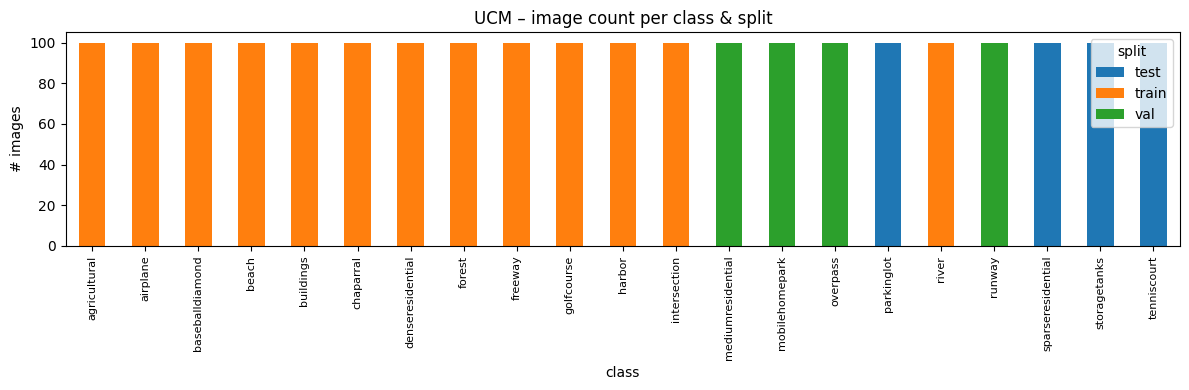

        dim          L2_norm        
      first   mean     first    mean
split                               
test    768  768.0  0.999023  0.9999
train   768  768.0  1.000000  0.9997
val     768  768.0  1.000000  0.9998


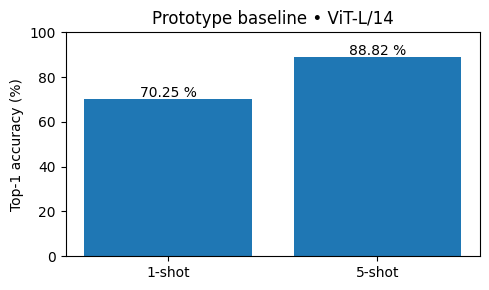

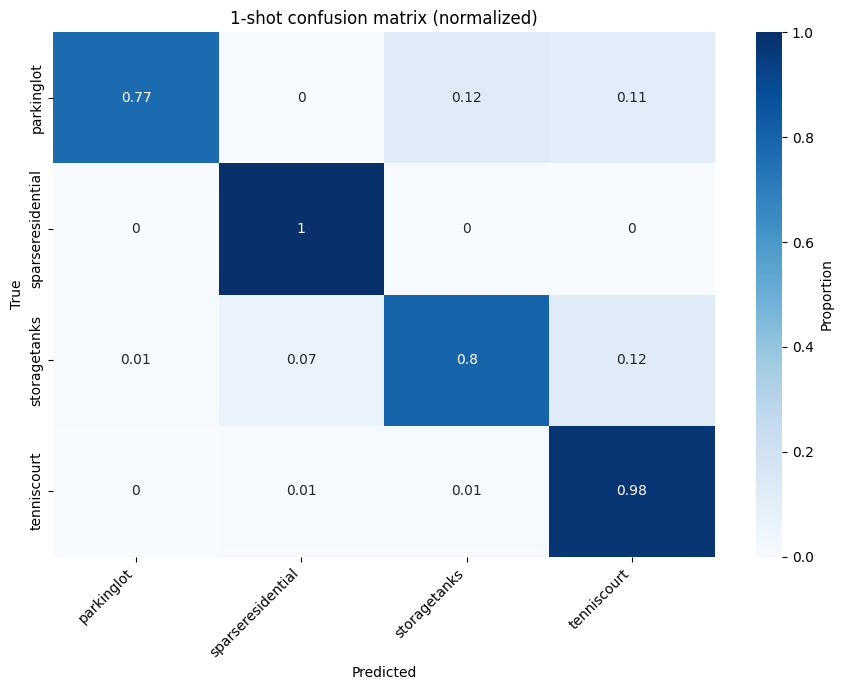

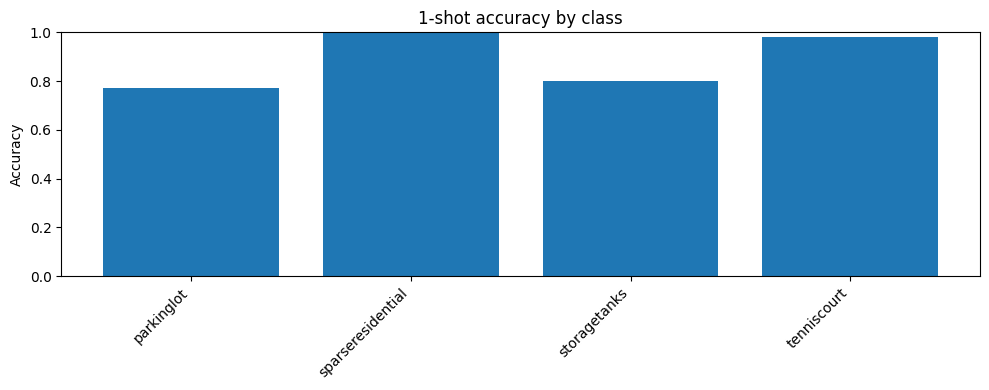


=== 1-shot classification report ===
                   precision    recall  f1-score   support

       parkinglot     0.9872    0.7700    0.8652       100
sparseresidential     0.9259    1.0000    0.9615       100
     storagetanks     0.8602    0.8000    0.8290       100
      tenniscourt     0.8099    0.9800    0.8869       100

         accuracy                         0.8875       400
        macro avg     0.8958    0.8875    0.8857       400
     weighted avg     0.8958    0.8875    0.8857       400



In [18]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# ---------- paths ------------------------------------------------------
SRC_ROOT  = Path(f"/kaggle/working/{DATASET}")                        # raw images
FEAT_ROOT = Path(f"/kaggle/working/clip_exp/features/{MODEL_NAME}/{DATASET}")
TEST_ROOT = FEAT_ROOT / "test"
test_classes = sorted(p.name for p in TEST_ROOT.iterdir() if p.is_dir())
# ----------------------------------------------------------------------

# 1) image counts per class & split ------------------------------------
records = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(SRC_ROOT / split)):
        records.append({
            "split":  split,
            "class":  cls,
            "n_imgs": len(list((SRC_ROOT / split / cls).glob("*")))
        })
pd.DataFrame(records).pivot(index="class", columns="split",
                            values="n_imgs").plot(kind="bar", stacked=True,
                                                  figsize=(12,4))
plt.ylabel("# images")
plt.title(f"{DATASET.upper()} – image count per class & split")
plt.xticks(rotation=90, ha="center", fontsize=8)
plt.tight_layout(); plt.show()

# 2) feature-vector sanity check ---------------------------------------
rows = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(FEAT_ROOT / split)):
        vec = np.load(next((FEAT_ROOT/split/cls).glob("*.npy")))
        rows.append({"split":split,"class":cls,
                     "dim":vec.shape[-1],"L2_norm":np.linalg.norm(vec)})
df_feat = pd.DataFrame(rows)
print(df_feat.groupby("split")[["dim","L2_norm"]].agg(["first","mean"]).round(4))

# 3) quick 1-shot inference -------------------------------------------
prototypes = {cls: np.load(next((TEST_ROOT/cls).glob("*.npy"))).squeeze()
              for cls in test_classes}
y_true, y_pred = [], []
for true_cls in test_classes:
    for fpath in (TEST_ROOT/true_cls).glob("*.npy"):
        feat = np.load(fpath).squeeze()
        sims = [np.dot(feat, prototypes[c]) for c in test_classes]
        y_true.append(true_cls)
        y_pred.append(test_classes[int(np.argmax(sims))])

# 4) bar plot of 1-shot / 5-shot --------------------------------------
plt.figure(figsize=(5,3))
bars = plt.bar(["1-shot","5-shot"], [acc1, acc5])
plt.ylim(0,100); plt.ylabel("Top-1 accuracy (%)")
plt.title(f"Prototype baseline • {MODEL_NAME}")
for b,v in zip(bars,[acc1,acc5]):
    plt.text(b.get_x()+b.get_width()/2, v+1, f"{v:.2f} %", ha="center")
plt.tight_layout(); plt.show()

# 5) confusion matrix & per-class acc ---------------------------------
cm = confusion_matrix(y_true, y_pred, labels=test_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, cmap="Blues", annot=True,
            xticklabels=test_classes, yticklabels=test_classes,
            cbar_kws={'label':'Proportion'})
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("1-shot confusion matrix (normalized)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

per_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(10,4))
plt.bar(test_classes, per_acc)
plt.xticks(rotation=45, ha="right"); plt.ylim(0,1)
plt.ylabel("Accuracy"); plt.title("1-shot accuracy by class")
plt.tight_layout(); plt.show()

# 6) detailed classification report -----------------------------------
print("\n=== 1-shot classification report ===")
print(classification_report(y_true, y_pred, target_names=test_classes, digits=4))

# 2 · Define train / val / test splits for AID

In [19]:
import os, shutil
from pathlib import Path

# Location of the raw images
SRC_ROOT = '/kaggle/input/aid-scene-classification-datasets/AID'
# Where the split directory tree will live
DST_ROOT = '/kaggle/working/aid'

# Clean up existing directory to start fresh
if os.path.exists(DST_ROOT):
    print(f"Removing existing directory: {DST_ROOT}")
    shutil.rmtree(DST_ROOT)
print(f"Creating fresh directory: {DST_ROOT}")
os.makedirs(DST_ROOT, exist_ok=True)

splits = {
    "train": [
        "Airport", "BareLand", "BaseballField", "Beach", "Bridge",
        "Center", "Church", "Commercial", "DenseResidential", "Desert",
        "Farmland", "Forest", "Industrial", "Meadow", "Mountain",
        "Park", "Parking", "Playground", "Pond", "Port"  # 20 classes
    ],
    "val": [
        "RailwayStation", "Resort", "River", "School", "SparseResidential"  # 5 classes
    ],
    "test": [
        "Square", "Stadium", "StorageTanks", "Viaduct", "MediumResidential"  # 5 classes
    ]
}

# (1) create empty folders
for split, classes in splits.items():
    for cls in classes:
        Path(DST_ROOT, split, cls).mkdir(parents=True, exist_ok=True)

# (2) copy images into the split folders
VALID_EXTS = ('.tif', '.tiff', '.jpg', '.jpeg', '.png')

for split, classes in splits.items():
    for cls in classes:
        src_dir = os.path.join(SRC_ROOT, cls)
        dst_dir = os.path.join(DST_ROOT, split, cls)
        
        if os.path.exists(src_dir):
            imgs = [f for f in os.listdir(src_dir) if f.lower().endswith(VALID_EXTS)]
            print(f"Copying {len(imgs)} imgs → {split}/{cls}")
            
            for img in imgs:
                shutil.copy(os.path.join(src_dir, img), dst_dir)
        else:
            print(f"Warning: {src_dir} does not exist")

# (3) quick report
for split in ["train", "val", "test"]:
    split_path = os.path.join(DST_ROOT, split)
    if os.path.exists(split_path):
        cls_list = sorted(os.listdir(split_path))
        print(f"✔ {split}: {len(cls_list)} classes → {cls_list}")
    else:
        print(f"✗ {split}: directory not found")

Creating fresh directory: /kaggle/working/aid
Copying 360 imgs → train/Airport
Copying 310 imgs → train/BareLand
Copying 220 imgs → train/BaseballField
Copying 400 imgs → train/Beach
Copying 360 imgs → train/Bridge
Copying 260 imgs → train/Center
Copying 240 imgs → train/Church
Copying 350 imgs → train/Commercial
Copying 410 imgs → train/DenseResidential
Copying 300 imgs → train/Desert
Copying 370 imgs → train/Farmland
Copying 250 imgs → train/Forest
Copying 390 imgs → train/Industrial
Copying 280 imgs → train/Meadow
Copying 340 imgs → train/Mountain
Copying 350 imgs → train/Park
Copying 390 imgs → train/Parking
Copying 370 imgs → train/Playground
Copying 420 imgs → train/Pond
Copying 380 imgs → train/Port
Copying 260 imgs → val/RailwayStation
Copying 290 imgs → val/Resort
Copying 410 imgs → val/River
Copying 300 imgs → val/School
Copying 300 imgs → val/SparseResidential
Copying 330 imgs → test/Square
Copying 290 imgs → test/Stadium
Copying 360 imgs → test/StorageTanks
Copying 420 imgs

In [20]:
import os

# Path to the target file in Kaggle environment
file_path = '/kaggle/working/VLM_FS-RSI-SC/classifier_fromFeatures.py'

# Define the new content you want to write into the file
new_code = '''import torch
print("Torch version:", torch.__version__)

from PIL import Image
from tqdm import tqdm
import numpy as np
import os

from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import argparse

import random
from scipy.special import softmax

# conda activate /media/admin1/envs/anaconda3/envs/lengEnv

def get_args_parser():

    parser = argparse.ArgumentParser('few-shot image scene classification', add_help=False)

    parser.add_argument('--sets', nargs='+', help="List of split", default=['test'])                         

    parser.add_argument('--root', default="/root/data1/image_scene_classification/blip_exp/features/", type=str,
                        help='path to exttracted features')
    
    parser.add_argument('--dataset', default='ucm', type=str,
                        help='data to test')

    parser.add_argument('--way', default=5, type=int,
                        help='number of classes')

    args = parser.parse_args()

    return args

#calculate prototypes using support sets
def fewshot_classifier(features_per_class):

    fewshot_weights = []

    for features in features_per_class:
        
        class_embedding = features.mean(axis=0)

        class_embedding /= np.linalg.norm(class_embedding)
        
        fewshot_weights.append(class_embedding)      

    fewshot_weights = np.stack(fewshot_weights, axis=1)

    return fewshot_weights


def main(args):

    if args.dataset == 'ucm':
        num_per_class = 100
        cls_num = 21
    
    if args.dataset == 'nwpu-resisc45':
        num_per_class = 700
        cls_num = 45
        
    if args.dataset == 'aid':
        num_per_class = 200  # AID dataset has ~200 images per class
        cls_num = 30  # AID has 30 total classes
        
    # repeat and avearage
    repeat_num = 50
    
    way = args.way
    
    # the sets to be evaluated, the train/val set is not used for training, the split is just following the original naming
    # sets = ['train', 'val', 'test']#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # sets = ['test']#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    sets = args.sets
    ####################################

    # device = "cuda" if torch.cuda.is_available() else "cpu"
    ##############################################read features
    all_features = []
    classes_all = []
    
    for split in sets:
        
        folder = args.root  + args.dataset + "/" + split + "/"
        classes = os.listdir(folder)
        classes=sorted(classes)
        print(classes)
        classes_all = classes_all + classes
    
        for cls in classes:
            # print(cls)
            image_features_class = []
            directory_path = folder + cls + "/"
            # Loop through each file in the directory
            for filename in os.listdir(directory_path): 
                file = os.path.join(directory_path, filename)
                feature = np.load(file)
                image_features_class.append(feature)

            image_features_class = np.stack(image_features_class, axis=0)
            # print(image_features_class.shape)(100, 1, 256)
            
            image_features_class = np.squeeze(image_features_class) 
            # print(image_features_class.shape)

            all_features.append(image_features_class)

    # print(len(all_features))#21
    # print(classes_all)
    
    if sets == ['train', 'val', 'test']:
        assert cls_num == len(classes_all)
    cls_num_test = len(classes_all)
    
    # For AID dataset, dynamically determine num_per_class based on actual data
    if args.dataset == 'aid':
        # Get the minimum number of images across all classes to ensure fair sampling
        min_images_per_class = min([len(features) for features in all_features])
        num_per_class = min_images_per_class
        print(f"AID dataset: Using {num_per_class} images per class (minimum available)")
    
    print('way number', way)
    print('split set', sets)
    print(f'Images per class: {num_per_class}')
    ############################################## N shot X way
    
    accuracy = np.zeros((2, repeat_num))
    row = 0
    for shot in [1, 5]:
        
        # repeat and avearage, if all classes are used for testing, each iteration outputs the same results
        for iter in np.arange(repeat_num):
            
            #way
            # select the novel class with the size of way
            numbers = list(range(0, cls_num_test))
            random.shuffle(numbers)
            # Select the first way classes from the shuffled list
            classes_test_idx = numbers[:way]
            # print(classes_test_idx)         
            
            #shot
            # Generate a list of numbers from 1 to num_per_class
            numbers = list(range(0, num_per_class))
            # Shuffle the list
            random.shuffle(numbers)
            # Select the first N numbers from the shuffled list, for the support set
            N = numbers[:shot]
            # Print the randomly chosen numbers
            # print(N)

            #obtain the support and query set
            support_set = []
            query_set = []
            query_counts = []  # Track actual query counts per class
            
            for cls_idx in classes_test_idx:#np.arange(len(classes_test)):

                support = all_features[cls_idx][N,:]
                support_set.append(support)

                #all queries
                class_queries = np.delete(all_features[cls_idx], N, axis=0)
                query_set.append(class_queries)
                query_counts.append(len(class_queries))  # Store actual count

            # print(query_set[0].shape)(99, 256)
            query_set  = np.row_stack(query_set)
            # print(query_set.shape)#(2079, 256)
            
            #labels - generate based on actual query counts per class
            targets = []
            for class_idx, count in enumerate(query_counts):
                targets.extend([class_idx] * count)
            targets = np.array(targets)

            # calculate the protypes using support set
            fewshot_weights = fewshot_classifier(support_set)

            # print(targets.shape, fewshot_weights.shape)#(2079,) (256, 21)

            #calculate similarity
            logits_image_image = 100. * query_set @ fewshot_weights
            probs_0 = softmax(logits_image_image, axis=-1)
            outputAll = np.uint8(np.argmax(probs_0, axis=1))
            
            # print(outputAll.shape)
            # calculate accuracy
            accuracy[row, iter] = accuracy_score(targets, outputAll)
            # print(accuracy)
            
        row = row + 1
 
    # print(accuracy)
    # Calculate the mean and standard deviation for each row
    row_means = np.mean(accuracy, axis=1)*100
    row_stds = np.std(accuracy, axis=1)
    
    # print(row_means,row_stds)
    output = f"{way}, {row_means[0]:.2f} ± {row_stds[0]:.2f},  {row_means[1]:.2f} ± {row_stds[1]:.2f}, {args.root}"
    print(args.root, output)
    
    # Write the data to the file
    with open('./acc.txt', 'a') as f:
        f.write(output)

if __name__ == '__main__':

    args = get_args_parser()

    main(args)
'''

# Write the new content, overwriting any existing file
with open(file_path, 'w') as f:
    f.write(new_code)

print(f"Successfully overwritten: {file_path}")

Successfully overwritten: /kaggle/working/VLM_FS-RSI-SC/classifier_fromFeatures.py


In [21]:
# ─────────────────────────────  Cell 3: AID  ─────────────────────────────
# --- CONFIG -----------------------------------------------------------
DATASET    = "aid"
MODEL_NAME = "ViT-L/14"
WAY        = 30
ROOT       = "/kaggle/working/"
# ---------------------------------------------------------------------

import os, subprocess, re

assert os.environ.get("REMOTECLIP_CKPT"), "Set REMOTECLIP_CKPT first!"

print(f"🔍 Extracting features for {DATASET} with {MODEL_NAME}…")
!python /kaggle/working/VLM_FS-RSI-SC/saveFeatures_subfolder_aid_nwpu_whu.py \
      --model_source clip \
      --model_name $MODEL_NAME \
      --root  $ROOT \
      --dataset $DATASET

🔍 Extracting features for aid with ViT-L/14…
Torch version: 2.6.0+cu124
2025-05-26 20:45:50.481502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748292350.503799     222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748292350.510661     222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/usr/local/lib/python3.11/dist-packages/fairscale/experimental/nn/offload.py:30: Fu

In [22]:
def get_acc(dataset, model_name, way):
    cmd = [
        "python", "/kaggle/working/VLM_FS-RSI-SC/classifier_fromFeatures.py",
        "--root",  f"{ROOT}clip_exp/features/{model_name}/",
        "--dataset", dataset,
        "--way",    str(way),
        "--sets",   "train", "val", "test"
    ]
    out = subprocess.run(cmd, capture_output=True, text=True).stdout
    m = re.search(r',\s*([\d.]+)\s*±.*?,\s*([\d.]+)\s*±', out)
    return (float(m.group(1)), float(m.group(2))) if m else (_:=out, None)

acc1, acc5 = get_acc(DATASET, MODEL_NAME, WAY)
print(f"✔ {DATASET.upper()} – 1-shot {acc1:.2f}%   5-shot {acc5:.2f}%")

✔ AID – 1-shot 66.03%   5-shot 88.67%


# 2.4 · EDA on the results 

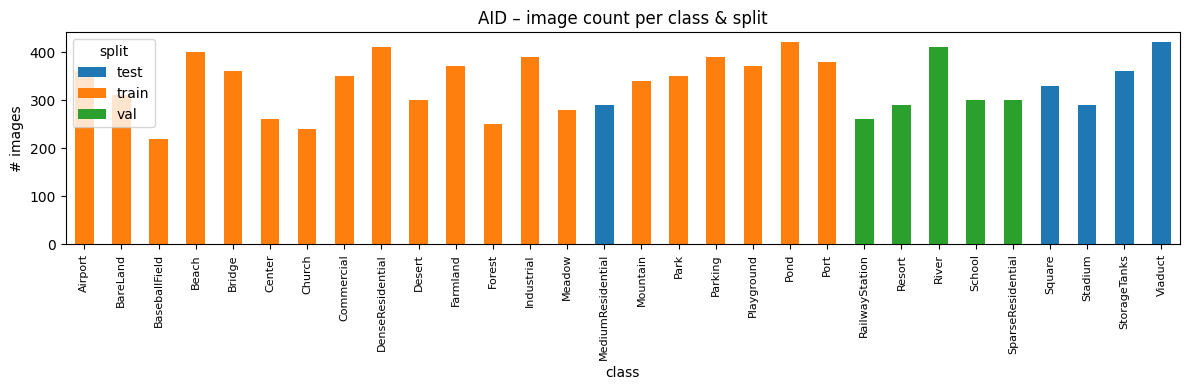

        dim          L2_norm        
      first   mean     first    mean
split                               
test    768  768.0  1.000000  0.9999
train   768  768.0  1.000000  0.9998
val     768  768.0  0.999023  0.9998


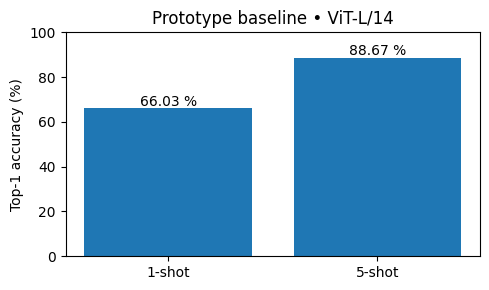

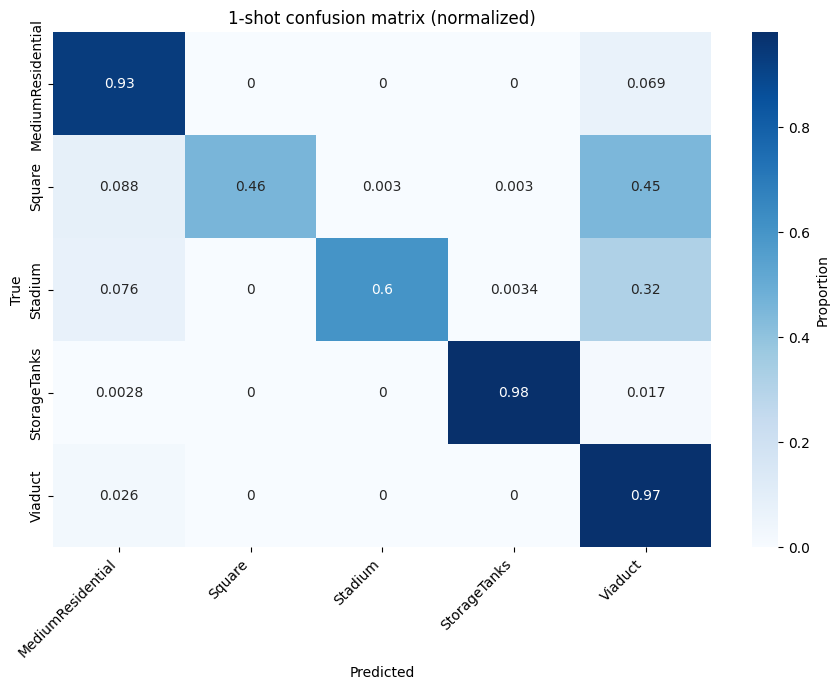

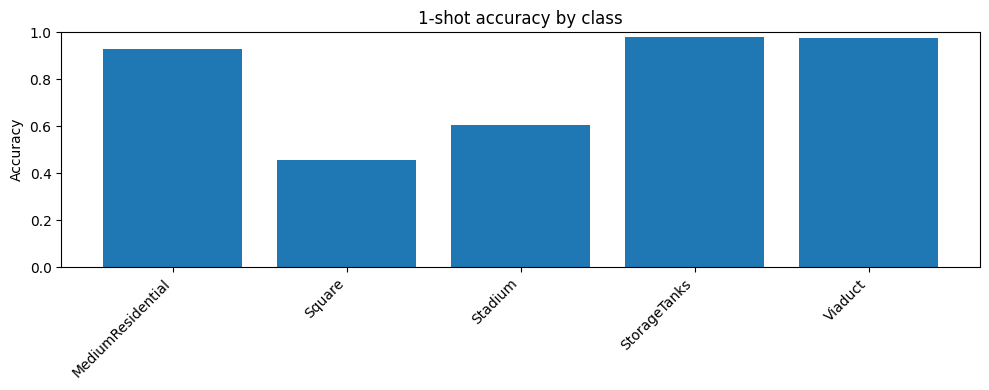


=== 1-shot classification report ===
                   precision    recall  f1-score   support

MediumResidential     0.8108    0.9310    0.8668       290
           Square     1.0000    0.4576    0.6279       330
          Stadium     0.9943    0.6034    0.7511       290
     StorageTanks     0.9944    0.9806    0.9874       360
          Viaduct     0.6059    0.9738    0.7470       420

         accuracy                         0.8036      1690
        macro avg     0.8811    0.7893    0.7960      1690
     weighted avg     0.8674    0.8036    0.7962      1690



In [23]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

# ---------- paths ------------------------------------------------------
SRC_ROOT  = Path(f"/kaggle/working/{DATASET}")                        # raw images
FEAT_ROOT = Path(f"/kaggle/working/clip_exp/features/{MODEL_NAME}/{DATASET}")
TEST_ROOT = FEAT_ROOT / "test"
test_classes = sorted(p.name for p in TEST_ROOT.iterdir() if p.is_dir())
# ----------------------------------------------------------------------

# 1) image counts per class & split ------------------------------------
records = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(SRC_ROOT / split)):
        records.append({
            "split":  split,
            "class":  cls,
            "n_imgs": len(list((SRC_ROOT / split / cls).glob("*")))
        })
pd.DataFrame(records).pivot(index="class", columns="split",
                            values="n_imgs").plot(kind="bar", stacked=True,
                                                  figsize=(12,4))
plt.ylabel("# images")
plt.title(f"{DATASET.upper()} – image count per class & split")
plt.xticks(rotation=90, ha="center", fontsize=8)
plt.tight_layout(); plt.show()

# 2) feature-vector sanity check ---------------------------------------
rows = []
for split in ["train", "val", "test"]:
    for cls in sorted(os.listdir(FEAT_ROOT / split)):
        vec = np.load(next((FEAT_ROOT/split/cls).glob("*.npy")))
        rows.append({"split":split,"class":cls,
                     "dim":vec.shape[-1],"L2_norm":np.linalg.norm(vec)})
df_feat = pd.DataFrame(rows)
print(df_feat.groupby("split")[["dim","L2_norm"]].agg(["first","mean"]).round(4))

# 3) quick 1-shot inference -------------------------------------------
prototypes = {cls: np.load(next((TEST_ROOT/cls).glob("*.npy"))).squeeze()
              for cls in test_classes}
y_true, y_pred = [], []
for true_cls in test_classes:
    for fpath in (TEST_ROOT/true_cls).glob("*.npy"):
        feat = np.load(fpath).squeeze()
        sims = [np.dot(feat, prototypes[c]) for c in test_classes]
        y_true.append(true_cls)
        y_pred.append(test_classes[int(np.argmax(sims))])

# 4) bar plot of 1-shot / 5-shot --------------------------------------
plt.figure(figsize=(5,3))
bars = plt.bar(["1-shot","5-shot"], [acc1, acc5])
plt.ylim(0,100); plt.ylabel("Top-1 accuracy (%)")
plt.title(f"Prototype baseline • {MODEL_NAME}")
for b,v in zip(bars,[acc1,acc5]):
    plt.text(b.get_x()+b.get_width()/2, v+1, f"{v:.2f} %", ha="center")
plt.tight_layout(); plt.show()

# 5) confusion matrix & per-class acc ---------------------------------
cm = confusion_matrix(y_true, y_pred, labels=test_classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(9,7))
sns.heatmap(cm_norm, cmap="Blues", annot=True,
            xticklabels=test_classes, yticklabels=test_classes,
            cbar_kws={'label':'Proportion'})
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("1-shot confusion matrix (normalized)")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

per_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(10,4))
plt.bar(test_classes, per_acc)
plt.xticks(rotation=45, ha="right"); plt.ylim(0,1)
plt.ylabel("Accuracy"); plt.title("1-shot accuracy by class")
plt.tight_layout(); plt.show()

# 6) detailed classification report -----------------------------------
print("\n=== 1-shot classification report ===")
print(classification_report(y_true, y_pred, target_names=test_classes, digits=4))